In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Activation

import warnings
warnings.filterwarnings('ignore')

In [4]:
def simulate_trading(close_price, predicted_change, trade_threshold):
    money = 100
    coins = 0
    for i in range(len(predicted_change) - 1):
        if predicted_change[i + 1] > trade_threshold:
            coins += money / close_price[i]
            money = 0
        elif predicted_change[i + 1] < trade_threshold:
            money += coins * close_price[i]
            coins = 0
    return money + coins * close_price[-1]

def simulate_holding(test):
    money = 100
    return (money / test[0]) * test[-1]

In [17]:
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X.iloc[i:(i + time_steps)].values
        Xs.append(v)
        ys.append(y.iloc[i + time_steps])
    return np.array(Xs), np.array(ys)

In [73]:
def read_train_evaluate(path='../data/6hour.csv', rolling=24, test_size=0.2, trading_threshold=0, plot=False):
    df = pd.read_csv(path)
    df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time']
    df['open_time'] = pd.to_datetime(df['open_time'] * 1000, unit='ms')
    df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
    df = df[df['open_time'] > '2020-01-01']
    df['ma'] = df['close_price'].rolling(rolling).mean()
    df['change'] = df['close_price'].pct_change() * 100
    df['future_change'] = df['change'].shift(-1)
    
    df = df.dropna()
    features = ['open_price', 'high_price', 'ma']
    target = 'future_change'
    X = df[features]
    y = df[target]

    time_steps = 10
    X, y = create_dataset(X, y, time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Flatten input data to scale, then reshape
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    model.add(Dropout(0.2))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(10))
    model.add(Dense(1))

    # Use a custom learning rate
    adam = tf.keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=adam, loss='mean_squared_error')

    # Train the model with different batch size and epochs
    history = model.fit(X_train_scaled, y_train, batch_size=5, epochs=5, validation_data=(X_test_scaled, y_test))

    # Predictions
    y_pred = model.predict(X_test_scaled)

    # Evaluation
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Mean Absolute Error: {mae}')
    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred, label='Predicted')
        plt.legend()
        plt.show()

    # Simulate trading
    close_price = df['close_price'].values[-len(y_pred):]
    predicted_change = y_pred.flatten()
    trading_result = simulate_trading(close_price, predicted_change, trading_threshold)
    holding_result = simulate_holding(close_price)
    
    return trading_result, holding_result


Epoch 1/5
754/754 [==============================] - 5s 4ms/step - loss: 5.9101 - val_loss: 5.3993
Epoch 2/5
754/754 [==============================] - 3s 3ms/step - loss: 5.8893 - val_loss: 5.3949
Epoch 3/5
754/754 [==============================] - 3s 3ms/step - loss: 5.8887 - val_loss: 5.3951
Epoch 4/5
754/754 [==============================] - 3s 3ms/step - loss: 5.8882 - val_loss: 5.4131
Epoch 5/5
30/30 [==============================] - 0s 2ms/step
Mean Absolute Error: 1.5506440594432913


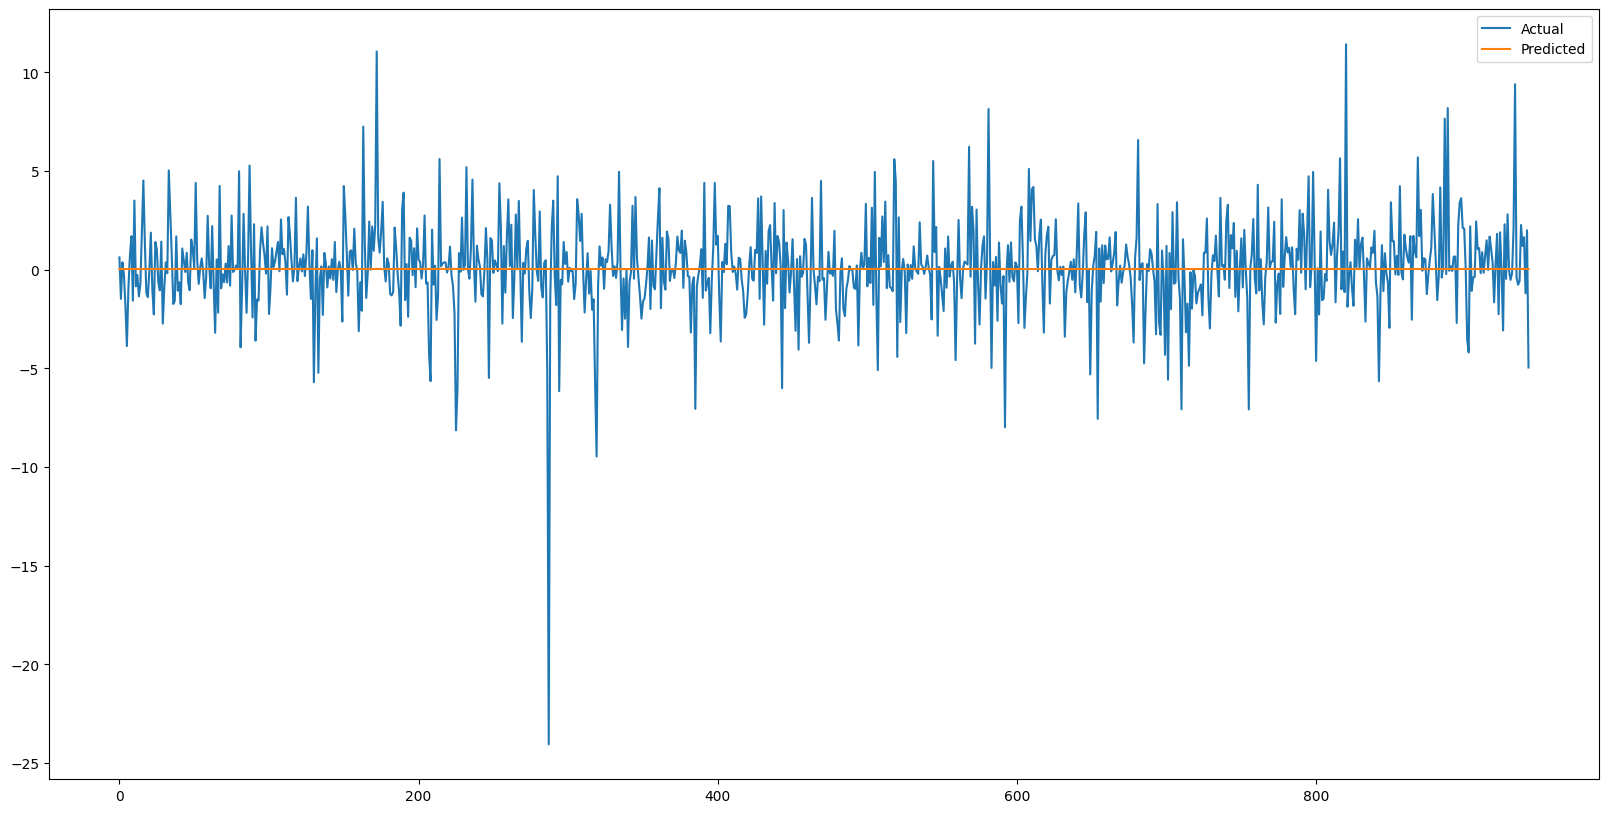

Trading result: 102.64426999803044
Holding result: 102.64426999803044


In [74]:
trading, holding = read_train_evaluate(plot=True, trading_threshold=0.001)
print(f'Trading result: {trading}')
print(f'Holding result: {holding}')

In [179]:
from sklearn.metrics import classification_report
from keras.layers import Dropout

def read_train_evaluate_binary(path='../data/1week.csv', rolling=6, time_steps=3, test_size=0.1, plot=False, df=None):
    if df is None:
        df = pd.read_csv(path)
        df.columns = ['open_time', 'open_price', 'high_price', 'low_price', 'close_price', 'volume', 'close_time']
        df['open_time'] = pd.to_datetime(df['open_time'] * 1000, unit='ms')
        df['close_time'] = pd.to_datetime(df['close_time'], unit='ms')
        df = df[df['open_time'] > '2020-01-01']
    df['ma'] = df['close_price'].rolling(rolling).mean()
    df['change'] = df['close_price'].pct_change()
    df['future_change'] = df['change'].shift(-1)
    
    df = df.dropna()
    
    features = ['close_price']
    target = 'future_change'
    X = df[features]
    y = (df[target] >= 0).astype(int)

    X, y = create_dataset(X, y, time_steps)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)

    # Flatten input data to scale, then reshape
    scaler = MinMaxScaler()
    X_train_scaled = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_test_scaled = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(20, return_sequences=True, input_shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])))
    # model.add(Dropout(0.2))
    model.add(LSTM(5, return_sequences=False))
    # model.add(Dense(10))
    model.add(Dense(1, activation='sigmoid'))

    # Use a custom learning rate
    adam = tf.keras.optimizers.legacy.Adam(learning_rate=0.001)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])

    # Train the model with different batch size and epochs
    history = model.fit(X_train_scaled, y_train, batch_size=4, epochs=10, validation_data=(X_test_scaled, y_test), verbose=1)

    # Predictions
    y_pred = model.predict(X_test_scaled)
    y_pred_class = (y_pred > 0.5).astype(int)

    # Evaluation
    report = (classification_report(y_test, y_pred_class))
    # weighted avg is the most important print it 
    # print(f'Accuracy: {history.history["accuracy"][-1]}')
    # trading_result = simulate_trading(df['close_price'].values[-len(y_pred_class):], y_pred_class.flatten(), 0.001)
    # holding_result = simulate_holding(df['close_price'].values[-len(y_pred_class):])
    # print(f'Trading result: {trading_result}')
    # print(f'Holding result: {holding_result}')

    if plot:
        plt.figure(figsize=(20, 10))
        plt.plot(y_test, label='Actual')
        plt.plot(y_pred_class, label='Predicted')
        plt.legend()
        plt.show()

    return history, df


In [119]:
history = read_train_evaluate_binary()

Epoch 1/50
128/128 [==============================] - 2s 4ms/step - loss: 0.6952 - accuracy: 0.5312 - val_loss: 0.6829 - val_accuracy: 0.5938
Epoch 2/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6914 - accuracy: 0.5547 - val_loss: 0.6779 - val_accuracy: 0.7500
Epoch 3/50
128/128 [==============================] - 0s 1ms/step - loss: 0.6912 - accuracy: 0.5234 - val_loss: 0.6722 - val_accuracy: 0.6875
Epoch 4/50
128/128 [==============================] - 0s 1ms/step - loss: 0.6903 - accuracy: 0.5625 - val_loss: 0.6661 - val_accuracy: 0.5938
Epoch 5/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6891 - accuracy: 0.5312 - val_loss: 0.6588 - val_accuracy: 0.6875
Epoch 6/50
128/128 [==============================] - 0s 2ms/step - loss: 0.6882 - accuracy: 0.5547 - val_loss: 0.6562 - val_accuracy: 0.7188
Epoch 7/50
128/128 [==============================] - 0s 1ms/step - loss: 0.6904 - accuracy: 0.5938 - val_loss: 0.6607 - val_accuracy: 0.7188
Epoch 

KeyboardInterrupt: 

In [180]:
time_steps = range(5, 10, 2)
rolling = range(3, 10, 2)
files = ['../data/1week.csv']
my_df = None

results = []

for t in time_steps:
    for r in rolling:
        for f in files:
            print(f'Running {t} time steps, {r} rolling')
            # print(f'Running {t} time steps, {r} rolling, {f} file')
            history, df = read_train_evaluate_binary(path=f, rolling=r, time_steps=t, df=my_df)
            if my_df is None:
                my_df = df
            results.append([t, r, f, history.history['accuracy'][-1]])
        

Running 5 time steps, 3 rolling
Epoch 1/10
36/36 [==============================] - 1s 12ms/step - loss: 0.6910 - accuracy: 0.4931 - val_loss: 0.7036 - val_accuracy: 0.2941
Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6867 - accuracy: 0.6181 - val_loss: 0.7139 - val_accuracy: 0.2941
Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6816 - accuracy: 0.6597 - val_loss: 0.7316 - val_accuracy: 0.3529
Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6745 - accuracy: 0.6667 - val_loss: 0.7485 - val_accuracy: 0.2941
Epoch 5/10
36/36 [==============================] - 0s 3ms/step - loss: 0.6679 - accuracy: 0.6667 - val_loss: 0.7823 - val_accuracy: 0.2941
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6596 - accuracy: 0.6319 - val_loss: 0.8243 - val_accuracy: 0.2941
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6540 - accuracy: 0.6597 - val_loss: 0.8471 - val_accu

In [181]:
for r in results:
    print(r)

[5, 3, '../data/1week.csv', 0.6458333134651184]
[5, 5, '../data/1week.csv', 0.6357142925262451]
[5, 7, '../data/1week.csv', 0.5942028760910034]
[5, 9, '../data/1week.csv', 0.595588207244873]
[7, 3, '../data/1week.csv', 0.6357142925262451]
[7, 5, '../data/1week.csv', 0.6014492511749268]
[7, 7, '../data/1week.csv', 0.5808823704719543]
[7, 9, '../data/1week.csv', 0.6222222447395325]
[9, 3, '../data/1week.csv', 0.6014492511749268]
[9, 5, '../data/1week.csv', 0.5882353186607361]
[9, 7, '../data/1week.csv', 0.6000000238418579]
[9, 9, '../data/1week.csv', 0.6015037298202515]


In [182]:
history, db = read_train_evaluate_binary(rolling=5, time_steps=4)

Epoch 1/10
36/36 [==============================] - 2s 12ms/step - loss: 0.6930 - accuracy: 0.4861 - val_loss: 0.6886 - val_accuracy: 0.6250
Epoch 2/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6906 - accuracy: 0.5556 - val_loss: 0.6864 - val_accuracy: 0.7500
Epoch 3/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6890 - accuracy: 0.5764 - val_loss: 0.6830 - val_accuracy: 0.7500
Epoch 4/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6874 - accuracy: 0.5556 - val_loss: 0.6796 - val_accuracy: 0.7500
Epoch 5/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6862 - accuracy: 0.6042 - val_loss: 0.6753 - val_accuracy: 0.7500
Epoch 6/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6848 - accuracy: 0.5972 - val_loss: 0.6725 - val_accuracy: 0.7500
Epoch 7/10
36/36 [==============================] - 0s 2ms/step - loss: 0.6818 - accuracy: 0.5764 - val_loss: 0.6662 - val_accuracy: 0.7500
Epoch 8/10
36/36 [=